<h1 style="text-align:center;">Practical session 13</h1>
<h2 style="text-align:center;">Biomedical Data Science</h2>
<h3 style="text-align:center;">Lucas Fayolle & Jose Valero</h3>

# Libraries

In [18]:
import numpy as np
import random
from scipy import ndimage
import pandas as pd
import matplotlib.pyplot as plt
import os
import json

import gc
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.models import load_model

# Data

In [2]:
# np.savez("processed_data.npz", x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val)

In [6]:
data = np.load("processed_data.npz")
x_train = data["x_train"]
y_train = data["y_train"]
x_val = data["x_val"]
y_val = data["y_val"]

In [7]:
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 140 and 60.


In [8]:
@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""
    def scipy_rotate(volume):
        angles = [-20, -10, -5, 5, 10, 20]
        angle = random.choice(angles)
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    augmented_volume.set_shape(volume.shape)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [9]:
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

I0000 00:00:1735057764.895399   35176 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


In [10]:
len(train_dataset)

70

In [11]:
len(validation_dataset)

30

# Training

## Functions

In [9]:
def train_model(model, train_dataset, validation_dataset, epochs=20):
    initial_lr = 1e-6       
    target_lr = 1e-5        
    warmup_epochs = 5      

    def scheduler(epoch, lr):
        if epoch < warmup_epochs:
            new_lr = initial_lr + (epoch * (target_lr - initial_lr) / warmup_epochs)
            return new_lr
        else:
            return target_lr

    model.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=initial_lr),
        metrics=["acc"]
    )

    checkpoint_cb = keras.callbacks.ModelCheckpoint(
        f"{model.name}.keras", save_best_only=True
    )
    early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

    lr_scheduler_cb = keras.callbacks.LearningRateScheduler(scheduler, verbose=0)

    history = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=epochs,
        shuffle=True,
        verbose=2,
        callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler_cb],
    )

    return history

In [10]:
def residual_block_3d(
    x, 
    filters, 
    activation="relu", 
    kernel_regularizer=keras.regularizers.l2(1e-5)
):
    shortcut = x

    y = layers.Conv3D(
        filters,
        kernel_size=3,
        padding="same",          
        activation=None,
        kernel_regularizer=kernel_regularizer
    )(x)
    y = layers.BatchNormalization()(y)
    y = layers.Activation(activation)(y)

    y = layers.Conv3D(
        filters,
        kernel_size=3,
        padding="same",
        activation=None,
        kernel_regularizer=kernel_regularizer
    )(y)
    y = layers.BatchNormalization()(y)

    if x.shape[-1] != filters:
        shortcut = layers.Conv3D(
            filters, 
            kernel_size=1,
            padding="same",
            activation=None,
            kernel_regularizer=kernel_regularizer
        )(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    y = layers.Add()([shortcut, y])
    y = layers.Activation(activation)(y)

    return y

In [11]:
def residual_inception_block_3d(
    x,
    filters,
    activation="relu",
    kernel_regularizer=keras.regularizers.l2(1e-5)
):
    """Inception-style 3D residual block."""
    shortcut = x
    
    path1 = layers.Conv3D(
        filters // 4,
        kernel_size=1,
        padding="same",
        activation=None,
        kernel_regularizer=kernel_regularizer
    )(x)
    path1 = layers.BatchNormalization()(path1)
    path1 = layers.Activation(activation)(path1)

    path2 = layers.Conv3D(
        filters // 4,
        kernel_size=1,
        padding="same",
        activation=None,
        kernel_regularizer=kernel_regularizer
    )(x)
    path2 = layers.BatchNormalization()(path2)
    path2 = layers.Activation(activation)(path2)
    path2 = layers.Conv3D(
        filters // 4,
        kernel_size=3,
        padding="same",
        activation=None,
        kernel_regularizer=kernel_regularizer
    )(path2)
    path2 = layers.BatchNormalization()(path2)
    path2 = layers.Activation(activation)(path2)

    path3 = layers.Conv3D(
        filters // 4,
        kernel_size=1,
        padding="same",
        activation=None,
        kernel_regularizer=kernel_regularizer
    )(x)
    path3 = layers.BatchNormalization()(path3)
    path3 = layers.Activation(activation)(path3)
    path3 = layers.Conv3D(
        filters // 4,
        kernel_size=5,
        padding="same",
        activation=None,
        kernel_regularizer=kernel_regularizer
    )(path3)
    path3 = layers.BatchNormalization()(path3)
    path3 = layers.Activation(activation)(path3)

    path4 = layers.MaxPool3D(pool_size=3, strides=1, padding="same")(x)
    path4 = layers.Conv3D(
        filters // 4,
        kernel_size=1,
        padding="same",
        activation=None,
        kernel_regularizer=kernel_regularizer
    )(path4)
    path4 = layers.BatchNormalization()(path4)
    path4 = layers.Activation(activation)(path4)

    merged = layers.Concatenate()([path1, path2, path3, path4])

    if merged.shape[-1] != filters:
        merged = layers.Conv3D(
            filters,
            kernel_size=1,
            padding="same",
            activation=None,
            kernel_regularizer=kernel_regularizer
        )(merged)
        merged = layers.BatchNormalization()(merged)

    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv3D(
            filters,
            kernel_size=1,
            padding="same",
            activation=None,
            kernel_regularizer=kernel_regularizer
        )(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    out = layers.Add()([shortcut, merged])
    out = layers.Activation(activation)(out)

    return out

In [12]:
def build_3d_cnn(
    width=128,
    height=128,
    depth=64,
    initial_filters=[64, 64, 128, 256],
    extra_dense=False,
    two_conv_per_level=False,
    activation="relu",
    pooling="max",
    use_residual=False,
    use_inception=False,
    name="3dcnn"
):
    inputs = keras.Input((width, height, depth, 1))
    x = inputs

    for f in initial_filters:
        if use_residual:
            x = residual_block_3d(
                x, 
                f, 
                activation=activation,
                kernel_regularizer=keras.regularizers.l2(1e-5)
            )
        elif use_inception:
            x = residual_inception_block_3d(
                x, 
                f, 
                activation=activation,
                kernel_regularizer=keras.regularizers.l2(1e-5)
            )
        else:
            x = layers.Conv3D(
                filters=f,
                kernel_size=3,
                padding="same",
                activation=activation,
                kernel_regularizer=keras.regularizers.l2(1e-5)
            )(x)
            if two_conv_per_level:
                x = layers.Conv3D(
                    filters=f,
                    kernel_size=3,
                    padding="same",
                    activation=activation,
                    kernel_regularizer=keras.regularizers.l2(1e-5)
                )(x)

        if pooling == "avg":
            x = layers.AveragePooling3D(pool_size=2)(x)
        else:
            x = layers.MaxPool3D(pool_size=2)(x)

        x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation=activation)(x)
    # x = layers.Dropout(0.5)(x)

    if extra_dense:
        x = layers.Dense(units=100, activation="relu")(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs, name=name)
    return model

# Configurations

In [13]:
def run_single_experiment(config_name, cfg, train_dataset, validation_dataset, epochs=20, results_path="results.csv", history_dir="histories", models_dir="models"):
    print(f"\n=== Entrenando modelo '{config_name}' ===")
    params = cfg["params"]

    os.makedirs(history_dir, exist_ok=True)
    os.makedirs(models_dir, exist_ok=True)

    model = build_3d_cnn(
        width=128,
        height=128,
        depth=64,
        **params,
        name=f"3dcnn_{config_name}"
    )
    model.summary()

    history = train_model(model, train_dataset, validation_dataset, epochs=epochs)
    
    final_train_acc = history.history["acc"][-1]
    final_val_acc = history.history["val_acc"][-1]

    result = {
        "config_name": config_name,
        "description": cfg["description"],
        "final_train_acc": final_train_acc,
        "final_val_acc": final_val_acc,
    }

    if not os.path.exists(results_path):
        pd.DataFrame([result]).to_csv(results_path, index=False)
    else:
        df = pd.read_csv(results_path)
        df = pd.concat([df, pd.DataFrame([result])], ignore_index=True)
        df.to_csv(results_path, index=False)

    history_path = os.path.join(history_dir, f"{config_name}_history.json")
    with open(history_path, "w") as f:
        json.dump(history.history, f)

    model_path = os.path.join(models_dir, f"{config_name}_model.h5")
    model.save(model_path)

    del model
    tf.keras.backend.clear_session()
    gc.collect()

    print(f"Resultados guardados en '{results_path}'")
    print(f"Historial guardado en '{history_path}'")
    print(f"Modelo guardado en '{model_path}'")

In [14]:
models_config = {
    "original": {
        "description": "Modelo base sin modificaciones",
        "params": {
            "extra_dense": False,
            "two_conv_per_level": False,
            "activation": "relu",
            "pooling": "max",
            "use_residual": False,
            "use_inception": False,
        },
    },
    "extra_dense": {
        "description": "Añade capa Dense de 100 unidades antes de la salida",
        "params": {
            "extra_dense": True,       
            "two_conv_per_level": False,
            "activation": "relu",
            "pooling": "max",
            "use_residual": False,
            "use_inception": False,
        },
    },
    "two_conv_per_level": {
        "description": "Agrega una segunda capa Conv3D en cada bloque",
        "params": {
            "extra_dense": False,
            "two_conv_per_level": True,  
            "activation": "relu",
            "pooling": "max",
            "use_residual": False,
            "use_inception": False,
        },
    },
    "relu_to_sigmoid": {
        "description": "Cambia la activación ReLU por sigmoid en todas las capas",
        "params": {
            "extra_dense": False,
            "two_conv_per_level": False,
            "activation": "sigmoid",  
            "pooling": "max",
            "use_residual": False,
            "use_inception": False,
        },
    },
    "max_to_avg_pooling": {
        "description": "Usa AveragePooling3D en lugar de MaxPooling3D",
        "params": {
            "extra_dense": False,
            "two_conv_per_level": False,
            "activation": "relu",
            "pooling": "avg",   
            "use_residual": False,
            "use_inception": False,
        },
    },
    "residual_blocks": {
        "description": "Reemplaza capas conv por bloques residuales",
        "params": {
            "initial_filters" : [32, 64, 128],
            "extra_dense": False,
            "two_conv_per_level": False,
            "activation": "relu",
            "pooling": "max",
            "use_residual": True,   
            "use_inception": False,
        },
    },
    "inception_blocks": {
        "description": "Reemplaza capas conv por bloques inception 3D",
        "params": {
            "initial_filters" : [32, 64, 128],
            "extra_dense": False,
            "two_conv_per_level": False,
            "activation": "relu",
            "pooling": "max",
            "use_residual": False,
            "use_inception": True,
        },
    },
}

In [16]:
# config_name = "original"
# cfg = models_config[config_name]

# run_single_experiment(
#     config_name=config_name,
#     cfg=cfg,
#     train_dataset=train_dataset,
#     validation_dataset=validation_dataset,
#     epochs=50,
#     results_path="results.csv",
#     history_dir="histories",
#     models_dir="models"
# )


=== Entrenando modelo 'original' ===


Model: "3dcnn_original"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 64,   │             0 │
│                                 │ 1)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 128, 128, 64,   │         1,792 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 64, 64, 32, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 64, 64, 32, 64) │       110,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 32, 32, 16, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 16, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 32, 32, 16,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 16, 16, 8, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 8, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 16, 16, 8, 256) │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 8, 8, 4, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 4, 256)   │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,352,897 (5.16 MB)

 Trainable params: 1,351,873 (5.16 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/50


I0000 00:00:1735052972.617718   14519 service.cc:148] XLA service 0x7fb6080080b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735052972.617756   14519 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-12-24 16:09:32.661336: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735052972.846097   14519 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-24 16:09:38.953603: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_reduce_reduce_window_fusion_3', 32 bytes spill stores, 32 bytes spill loads

I0000 00:00:1735052978.963309   14519 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


70/70 - 18s - 262ms/step - acc: 0.6071 - loss: 0.6852 - val_acc: 0.5000 - val_loss: 0.6966 - learning_rate: 1.0000e-06
Epoch 2/50
70/70 - 10s - 141ms/step - acc: 0.5786 - loss: 0.6884 - val_acc: 0.5000 - val_loss: 0.7119 - learning_rate: 2.8000e-06
Epoch 3/50
70/70 - 10s - 141ms/step - acc: 0.6071 - loss: 0.6755 - val_acc: 0.5000 - val_loss: 0.8198 - learning_rate: 4.6000e-06
Epoch 4/50
70/70 - 10s - 140ms/step - acc: 0.5571 - loss: 0.6843 - val_acc: 0.5000 - val_loss: 1.1314 - learning_rate: 6.4000e-06
Epoch 5/50
70/70 - 9s - 123ms/step - acc: 0.5357 - loss: 0.6933 - val_acc: 0.5000 - val_loss: 0.9945 - learning_rate: 8.2000e-06
Epoch 6/50
70/70 - 10s - 141ms/step - acc: 0.6214 - loss: 0.6745 - val_acc: 0.5000 - val_loss: 1.3803 - learning_rate: 1.0000e-05
Epoch 7/50
70/70 - 10s - 139ms/step - acc: 0.5929 - loss: 0.6698 - val_acc: 0.5000 - val_loss: 1.2347 - learning_rate: 1.0000e-05
Epoch 8/50
70/70 - 9s - 126ms/step - acc: 0.5429 - loss: 0.6841 - val_acc: 0.5000 - val_loss: 0.8755 -

Resultados guardados en 'results.csv'
Historial guardado en 'histories/original_history.json'
Modelo guardado en 'models/original_model.h5'


In [16]:
# config_name = "extra_dense"
# cfg = models_config[config_name]

# run_single_experiment(
#     config_name=config_name,
#     cfg=cfg,
#     train_dataset=train_dataset,
#     validation_dataset=validation_dataset,
#     epochs=50,
#     results_path="results.csv",
#     history_dir="histories",
#     models_dir="models"
# )


=== Entrenando modelo 'extra_dense' ===


Model: "3dcnn_extra_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 64,   │             0 │
│                                 │ 1)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 128, 128, 64,   │         1,792 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 64, 64, 32, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 64, 64, 32, 64) │       110,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 32, 32, 16, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 16, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 32, 32, 16,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 16, 16, 8, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 8, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 16, 16, 8, 256) │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 8, 8, 4, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 4, 256)   │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,403,785 (5.36 MB)

 Trainable params: 1,402,761 (5.35 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/50


I0000 00:00:1735053769.679174   17850 service.cc:148] XLA service 0x7f05dc026a70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735053769.679210   17850 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-12-24 16:22:49.724054: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735053769.914378   17850 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-24 16:22:55.354870: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_reduce_reduce_window_fusion_3', 32 bytes spill stores, 32 bytes spill loads

I0000 00:00:1735053775.364397   17850 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


70/70 - 18s - 263ms/step - acc: 0.5214 - loss: 0.6959 - val_acc: 0.5000 - val_loss: 0.6969 - learning_rate: 1.0000e-06
Epoch 2/50
70/70 - 10s - 137ms/step - acc: 0.5643 - loss: 0.6921 - val_acc: 0.5000 - val_loss: 0.7090 - learning_rate: 2.8000e-06
Epoch 3/50
70/70 - 8s - 118ms/step - acc: 0.5929 - loss: 0.6910 - val_acc: 0.5000 - val_loss: 0.7804 - learning_rate: 4.6000e-06
Epoch 4/50
70/70 - 9s - 133ms/step - acc: 0.6500 - loss: 0.6801 - val_acc: 0.5000 - val_loss: 0.9667 - learning_rate: 6.4000e-06
Epoch 5/50
70/70 - 9s - 135ms/step - acc: 0.6357 - loss: 0.6762 - val_acc: 0.5000 - val_loss: 1.1269 - learning_rate: 8.2000e-06
Epoch 6/50
70/70 - 9s - 134ms/step - acc: 0.6571 - loss: 0.6612 - val_acc: 0.5000 - val_loss: 1.3748 - learning_rate: 1.0000e-05
Epoch 7/50
70/70 - 8s - 120ms/step - acc: 0.5714 - loss: 0.6670 - val_acc: 0.5000 - val_loss: 1.2806 - learning_rate: 1.0000e-05
Epoch 8/50
70/70 - 10s - 136ms/step - acc: 0.6357 - loss: 0.6645 - val_acc: 0.5000 - val_loss: 1.2197 - le

Resultados guardados en 'results.csv'
Historial guardado en 'histories/extra_dense_history.json'
Modelo guardado en 'models/extra_dense_model.h5'


In [17]:
# config_name = "two_conv_per_level"
# cfg = models_config[config_name]

# run_single_experiment(
#     config_name=config_name,
#     cfg=cfg,
#     train_dataset=train_dataset,
#     validation_dataset=validation_dataset,
#     epochs=50,
#     results_path="results.csv",
#     history_dir="histories",
#     models_dir="models"
# )


=== Entrenando modelo 'two_conv_per_level' ===


Model: "3dcnn_two_conv_per_level"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 64,   │             0 │
│                                 │ 1)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 128, 128, 64,   │         1,792 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 128, 128, 64,   │       110,656 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 64, 64, 32, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 64, 64, 32, 64) │       110,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 64, 64, 32, 64) │       110,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 32, 32, 16, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 16, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 32, 32, 16,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 32, 32, 16,     │       442,496 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 16, 16, 8, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 8, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_6 (Conv3D)               │ (None, 16, 16, 8, 256) │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_7 (Conv3D)               │ (None, 16, 16, 8, 256) │     1,769,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 8, 8, 4, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 4, 256)   │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           51

 Total params: 3,786,433 (14.44 MB)

 Trainable params: 3,785,409 (14.44 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/50


I0000 00:00:1735054384.137162   21191 service.cc:148] XLA service 0x7f7890002610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735054384.137201   21191 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-12-24 16:33:04.206504: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735054384.426640   21191 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-24 16:33:09.432594: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[2,64,128,128,64]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[2,64,128,128,64]{4,3,2,1,0}, f32[64,64,3,3,3]{4,3,2,1,0}, f32[64]{0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation

70/70 - 53s - 750ms/step - acc: 0.4929 - loss: 0.7022 - val_acc: 0.5000 - val_loss: 0.7047 - learning_rate: 1.0000e-06
Epoch 2/50
70/70 - 22s - 311ms/step - acc: 0.5929 - loss: 0.6916 - val_acc: 0.5000 - val_loss: 0.7013 - learning_rate: 2.8000e-06
Epoch 3/50
70/70 - 21s - 295ms/step - acc: 0.5857 - loss: 0.6912 - val_acc: 0.5000 - val_loss: 0.7000 - learning_rate: 4.6000e-06
Epoch 4/50
70/70 - 21s - 294ms/step - acc: 0.5643 - loss: 0.6890 - val_acc: 0.5000 - val_loss: 0.7015 - learning_rate: 6.4000e-06
Epoch 5/50
70/70 - 22s - 307ms/step - acc: 0.6000 - loss: 0.6834 - val_acc: 0.5000 - val_loss: 0.8309 - learning_rate: 8.2000e-06
Epoch 6/50
70/70 - 20s - 292ms/step - acc: 0.6714 - loss: 0.6643 - val_acc: 0.5000 - val_loss: 1.0052 - learning_rate: 1.0000e-05
Epoch 7/50
70/70 - 20s - 292ms/step - acc: 0.5214 - loss: 0.6984 - val_acc: 0.5000 - val_loss: 0.9853 - learning_rate: 1.0000e-05
Epoch 8/50
70/70 - 21s - 307ms/step - acc: 0.6643 - loss: 0.6640 - val_acc: 0.5000 - val_loss: 0.9465

Resultados guardados en 'results.csv'
Historial guardado en 'histories/two_conv_per_level_history.json'
Modelo guardado en 'models/two_conv_per_level_model.h5'


In [15]:
# config_name = "relu_to_sigmoid"
# cfg = models_config[config_name]

# run_single_experiment(
#     config_name=config_name,
#     cfg=cfg,
#     train_dataset=train_dataset,
#     validation_dataset=validation_dataset,
#     epochs=50,
#     results_path="results.csv",
#     history_dir="histories",
#     models_dir="models"
# )


=== Entrenando modelo 'relu_to_sigmoid' ===


Model: "3dcnn_relu_to_sigmoid"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 64,   │             0 │
│                                 │ 1)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 128, 128, 64,   │         1,792 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 64, 64, 32, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 64, 64, 32, 64) │       110,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 32, 32, 16, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 16, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 32, 32, 16,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 16, 16, 8, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 8, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 16, 16, 8, 256) │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 8, 8, 4, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 4, 256)   │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,352,897 (5.16 MB)

 Trainable params: 1,351,873 (5.16 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/50


I0000 00:00:1735055511.070940   25315 service.cc:148] XLA service 0x7f76140186e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735055511.070975   25315 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-12-24 16:51:51.114819: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735055511.285850   25315 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1735055516.714718   25315 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


70/70 - 17s - 244ms/step - acc: 0.5000 - loss: 0.7277 - val_acc: 0.5000 - val_loss: 0.7290 - learning_rate: 1.0000e-06
Epoch 2/50
70/70 - 10s - 136ms/step - acc: 0.5000 - loss: 0.7230 - val_acc: 0.5000 - val_loss: 0.7295 - learning_rate: 2.8000e-06
Epoch 3/50
70/70 - 9s - 135ms/step - acc: 0.5000 - loss: 0.7175 - val_acc: 0.5000 - val_loss: 0.7210 - learning_rate: 4.6000e-06
Epoch 4/50
70/70 - 8s - 120ms/step - acc: 0.5000 - loss: 0.7142 - val_acc: 0.5000 - val_loss: 0.7009 - learning_rate: 6.4000e-06
Epoch 5/50
70/70 - 10s - 136ms/step - acc: 0.5286 - loss: 0.6910 - val_acc: 0.5000 - val_loss: 0.6991 - learning_rate: 8.2000e-06
Epoch 6/50
70/70 - 9s - 135ms/step - acc: 0.5286 - loss: 0.6877 - val_acc: 0.5000 - val_loss: 0.8111 - learning_rate: 1.0000e-05
Epoch 7/50
70/70 - 8s - 118ms/step - acc: 0.5857 - loss: 0.6849 - val_acc: 0.5000 - val_loss: 0.9131 - learning_rate: 1.0000e-05
Epoch 8/50
70/70 - 9s - 134ms/step - acc: 0.5786 - loss: 0.6787 - val_acc: 0.5000 - val_loss: 0.9201 - le

Resultados guardados en 'results.csv'
Historial guardado en 'histories/relu_to_sigmoid_history.json'
Modelo guardado en 'models/relu_to_sigmoid_model.h5'


In [30]:
# config_name = "max_to_avg_pooling"
# cfg = models_config[config_name]

# run_single_experiment(
#     config_name=config_name,
#     cfg=cfg,
#     train_dataset=train_dataset,
#     validation_dataset=validation_dataset,
#     epochs=50,
#     results_path="results.csv",
#     history_dir="histories",
#     models_dir="models"
# )


=== Entrenando modelo 'max_to_avg_pooling' ===


Model: "3dcnn_max_to_avg_pooling"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 64,   │             0 │
│                                 │ 1)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 128, 128, 64,   │         1,792 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling3d               │ (None, 64, 64, 32, 64) │             0 │
│ (AveragePooling3D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 64, 64, 32, 64) │       110,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling3d_1             │ (None, 32, 32, 16, 64) │             0 │
│ (AveragePooling3D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 16, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 32, 32, 16,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling3d_2             │ (None, 16, 16, 8, 128) │             0 │
│ (AveragePooling3D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 8, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 16, 16, 8, 256) │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling3d_3             │ (None, 8, 8, 4, 256)   │             0 │
│ (AveragePooling3D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 4, 256)   │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,352,897 (5.16 MB)

 Trainable params: 1,351,873 (5.16 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/50


2024-12-24 16:59:59.650665: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_3', 88 bytes spill stores, 88 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_2', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_reduce_window_fusion_3', 40 bytes spill stores, 40 bytes spill loads



70/70 - 15s - 217ms/step - acc: 0.4929 - loss: 0.6961 - val_acc: 0.5000 - val_loss: 0.6983 - learning_rate: 1.0000e-06
Epoch 2/50
70/70 - 9s - 130ms/step - acc: 0.5357 - loss: 0.6927 - val_acc: 0.5000 - val_loss: 0.7020 - learning_rate: 2.8000e-06
Epoch 3/50
70/70 - 10s - 145ms/step - acc: 0.5929 - loss: 0.6830 - val_acc: 0.5000 - val_loss: 0.6945 - learning_rate: 4.6000e-06
Epoch 4/50
70/70 - 10s - 145ms/step - acc: 0.6143 - loss: 0.6741 - val_acc: 0.5000 - val_loss: 0.7073 - learning_rate: 6.4000e-06
Epoch 5/50
70/70 - 9s - 127ms/step - acc: 0.5571 - loss: 0.6879 - val_acc: 0.5000 - val_loss: 0.7097 - learning_rate: 8.2000e-06
Epoch 6/50
70/70 - 10s - 146ms/step - acc: 0.6286 - loss: 0.6670 - val_acc: 0.4833 - val_loss: 0.6917 - learning_rate: 1.0000e-05
Epoch 7/50
70/70 - 10s - 148ms/step - acc: 0.5714 - loss: 0.6853 - val_acc: 0.5000 - val_loss: 0.7159 - learning_rate: 1.0000e-05
Epoch 8/50
70/70 - 9s - 129ms/step - acc: 0.6714 - loss: 0.6503 - val_acc: 0.5000 - val_loss: 0.8325 - 

Resultados guardados en 'results.csv'
Historial guardado en 'histories/max_to_avg_pooling_history.json'
Modelo guardado en 'models/max_to_avg_pooling_model.h5'


In [15]:
# config_name = "residual_blocks"
# cfg = models_config[config_name]

# run_single_experiment(
#     config_name=config_name,
#     cfg=cfg,
#     train_dataset=train_dataset,
#     validation_dataset=validation_dataset,
#     epochs=50,
#     results_path="results.csv",
#     history_dir="histories",
#     models_dir="models"
# )


=== Entrenando modelo 'residual_blocks' ===


Model: "3dcnn_residual_blocks"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 64, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv3d[0][0]      │
│ (BatchNormalizatio… │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 128, 128,  │         64 │ input_layer[0][0] │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 128, 128,  │     27,680 │ activation[0][0]  │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv3d_2[0][0]    │
│ (BatchNormalizatio… │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv3d_1[0][0]    │
│ (BatchNormalizatio… │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64, 32)           │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ add[0][0]         │
│ (Activation)        │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling3D)      │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ max_pooling3d[0]… │
│ (BatchNormalizatio… │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 64, 64,    │     55,360 │ batch_normalizat… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv3d_3[0][0]    │
│ (BatchNormalizatio… │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 64, 64,    │      2,112 │ batch_normalizat… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 64, 64,    │    110,656 │ activation_2[0][

 Total params: 939,041 (3.58 MB)

 Trainable params: 937,249 (3.58 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/50


I0000 00:00:1735056348.897209   30876 service.cc:148] XLA service 0x7fc878003f20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735056348.897246   30876 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-12-24 17:05:48.978756: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735056349.352163   30876 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-24 17:05:49.810280: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3500', 4 bytes spill stores, 4 bytes spill loads

E0000 00:00:1735056350.765990   30876 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0

70/70 - 35s - 494ms/step - acc: 0.6000 - loss: 0.6944 - val_acc: 0.5000 - val_loss: 0.7016 - learning_rate: 1.0000e-06
Epoch 2/50
70/70 - 13s - 185ms/step - acc: 0.5214 - loss: 0.6949 - val_acc: 0.5000 - val_loss: 0.7134 - learning_rate: 2.8000e-06
Epoch 3/50
70/70 - 14s - 201ms/step - acc: 0.5857 - loss: 0.6905 - val_acc: 0.5000 - val_loss: 0.7265 - learning_rate: 4.6000e-06
Epoch 4/50
70/70 - 13s - 184ms/step - acc: 0.5857 - loss: 0.6853 - val_acc: 0.5000 - val_loss: 0.7681 - learning_rate: 6.4000e-06
Epoch 5/50
70/70 - 14s - 201ms/step - acc: 0.5857 - loss: 0.6863 - val_acc: 0.5000 - val_loss: 0.8154 - learning_rate: 8.2000e-06
Epoch 6/50
70/70 - 14s - 201ms/step - acc: 0.5786 - loss: 0.6829 - val_acc: 0.5000 - val_loss: 0.8656 - learning_rate: 1.0000e-05
Epoch 7/50
70/70 - 13s - 183ms/step - acc: 0.6143 - loss: 0.6693 - val_acc: 0.5000 - val_loss: 0.8301 - learning_rate: 1.0000e-05
Epoch 8/50
70/70 - 14s - 200ms/step - acc: 0.5857 - loss: 0.6750 - val_acc: 0.5000 - val_loss: 0.7557

Resultados guardados en 'results.csv'
Historial guardado en 'histories/residual_blocks_history.json'
Modelo guardado en 'models/residual_blocks_model.h5'


In [15]:
# config_name = "inception_blocks"
# cfg = models_config[config_name]

# run_single_experiment(
#     config_name=config_name,
#     cfg=cfg,
#     train_dataset=train_dataset,
#     validation_dataset=validation_dataset,
#     epochs=50,
#     results_path="results.csv",
#     history_dir="histories",
#     models_dir="models"
# )


=== Entrenando modelo 'inception_blocks' ===


Model: "3dcnn_inception_blocks"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 64, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 128, 128,  │         16 │ input_layer[0][0] │
│                     │ 64, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 128, 128,  │         16 │ input_layer[0][0] │
│                     │ 64, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         32 │ conv3d_1[0][0]    │
│ (BatchNormalizatio… │ 64, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         32 │ conv3d_3[0][0]    │
│ (BatchNormalizatio… │ 64, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (MaxPooling3D)      │ 64, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 128, 128,  │         16 │ input_layer[0][0] │
│                     │ 64, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 128, 128,  │      1,736 │ activation_1[0][… │
│                     │ 64, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 128, 128,  │      8,008 │ activation_3[0][… │
│                     │ 64, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 128, 128,  │         16 │ max_pooling3d[0]… │
│                     │ 64, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │         32 │ conv3d[0][0]      │
│ (BatchNormalizatio… │ 64, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         32 │ conv3d_2[0][0]    │
│ (BatchNormalizatio… │ 64, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         32 │ conv3d_4[0][0]    │
│ (BatchNormalizatio… │ 64, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         32 │ conv3d_5[0][0]    │
│ (BatchNormalizatio… │ 64, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_6 (Conv3D)   │ (None, 128, 128,  │         64 │ input_layer[0][0

 Total params: 295,089 (1.13 MB)

 Trainable params: 293,521 (1.12 MB)

 Non-trainable params: 1,568 (6.12 KB)

Epoch 1/50


I0000 00:00:1735056750.525103   32993 service.cc:148] XLA service 0x7f8f8c0029a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735056750.525164   32993 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-12-24 17:12:30.693137: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735056751.453684   32993 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-24 17:12:32.167337: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7214', 4 bytes spill stores, 4 bytes spill loads

E0000 00:00:1735056758.070992   32993 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0

70/70 - 47s - 668ms/step - acc: 0.4571 - loss: 0.6982 - val_acc: 0.5000 - val_loss: 0.7165 - learning_rate: 1.0000e-06
Epoch 2/50
70/70 - 14s - 193ms/step - acc: 0.4857 - loss: 0.6946 - val_acc: 0.5000 - val_loss: 0.7214 - learning_rate: 2.8000e-06
Epoch 3/50
70/70 - 12s - 178ms/step - acc: 0.5500 - loss: 0.6924 - val_acc: 0.5167 - val_loss: 0.7002 - learning_rate: 4.6000e-06
Epoch 4/50
70/70 - 13s - 193ms/step - acc: 0.6071 - loss: 0.6881 - val_acc: 0.4833 - val_loss: 0.7054 - learning_rate: 6.4000e-06
Epoch 5/50
70/70 - 12s - 175ms/step - acc: 0.5286 - loss: 0.6976 - val_acc: 0.5000 - val_loss: 0.7206 - learning_rate: 8.2000e-06
Epoch 6/50
70/70 - 13s - 192ms/step - acc: 0.6214 - loss: 0.6852 - val_acc: 0.5000 - val_loss: 0.7193 - learning_rate: 1.0000e-05
Epoch 7/50
70/70 - 12s - 177ms/step - acc: 0.5500 - loss: 0.6847 - val_acc: 0.5000 - val_loss: 0.6978 - learning_rate: 1.0000e-05
Epoch 8/50
70/70 - 14s - 194ms/step - acc: 0.6143 - loss: 0.6801 - val_acc: 0.5667 - val_loss: 0.6771

Resultados guardados en 'results.csv'
Historial guardado en 'histories/inception_blocks_history.json'
Modelo guardado en 'models/inception_blocks_model.h5'


# Results

## Functions

In [12]:
def plot_training_history(history, config_name):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    ax = ax.ravel()

    for i, metric in enumerate(["acc", "loss"]):
        ax[i].plot(history[metric])
        ax[i].plot(history["val_" + metric])
        ax[i].set_title(f"{config_name} - {metric.capitalize()}")
        ax[i].set_xlabel("Epochs")
        ax[i].set_ylabel(metric.capitalize())
        ax[i].legend(["Train", "Validation"])
        ax[i].grid(True)

    plt.tight_layout()
    plt.show()

In [13]:
def make_predictions(model, x_val = x_val, class_names = ["normal", "abnormal"]):
    predictions = model.predict(np.expand_dims(x_val[0], axis=0))[0]
    scores = [1 - predictions[0], predictions[0]]

    for score, name in zip(scores, class_names):
        print(
            f"This model is {100 * score:.2f}% confident that the CT scan is {name}."
        )

## Performance

### Best model

In [14]:
df_results = pd.read_csv("results.csv")
df_results

,config_name,description,final_train_acc,final_val_acc
0,original,Modelo base sin modificaciones,0.692857,0.750000
1,extra_dense,Añade capa Dense de 100 unidades antes de la s...,0.657143,0.566667
2,two_conv_per_level,Agrega una segunda capa Conv3D en cada bloque,0.814286,0.766667
3,relu_to_sigmoid,Cambia la activación ReLU por sigmoid en todas...,0.657143,0.716667
4,max_to_avg_pooling,Usa AveragePooling3D en lugar de MaxPooling3D,0.578571,0.716667
5,residual_blocks,Reemplaza capas conv por bloques residuales,0.657143,0.666667
6,inception_blocks,Reemplaza capas conv por bloques inception 3D,0.557143,0.700000


In [15]:
best_model_row = df_results[df_results['final_val_acc'] == df_results['final_val_acc'].max()].iloc[0]

print("Mejor modelo:\n")
for key, value in best_model_row.items():
    print(f"{key}: {value}")

Mejor modelo:

config_name: two_conv_per_level
description: Agrega una segunda capa Conv3D en cada bloque
final_train_acc: 0.8142856955528259
final_val_acc: 0.7666666507720947


### Analysis of the stories

=== Gráficos para configuración: original ===


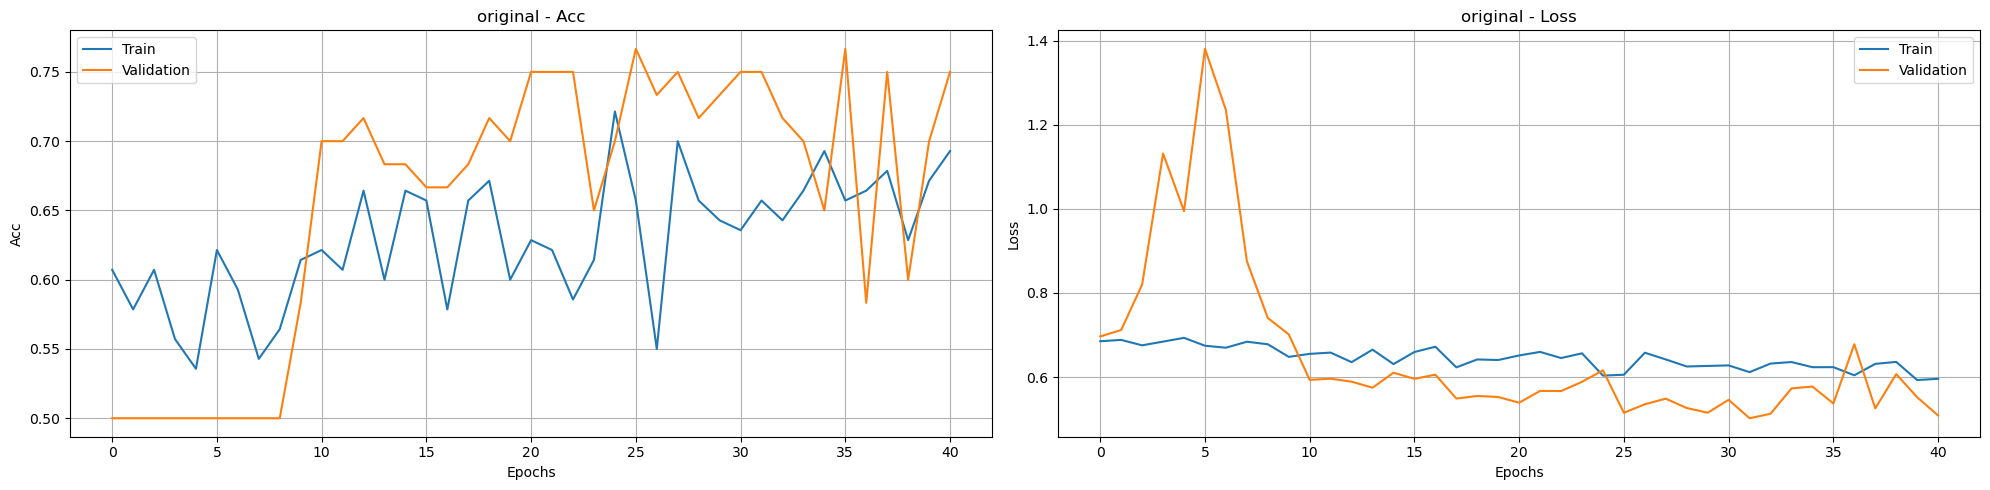

=== Gráficos para configuración: extra_dense ===


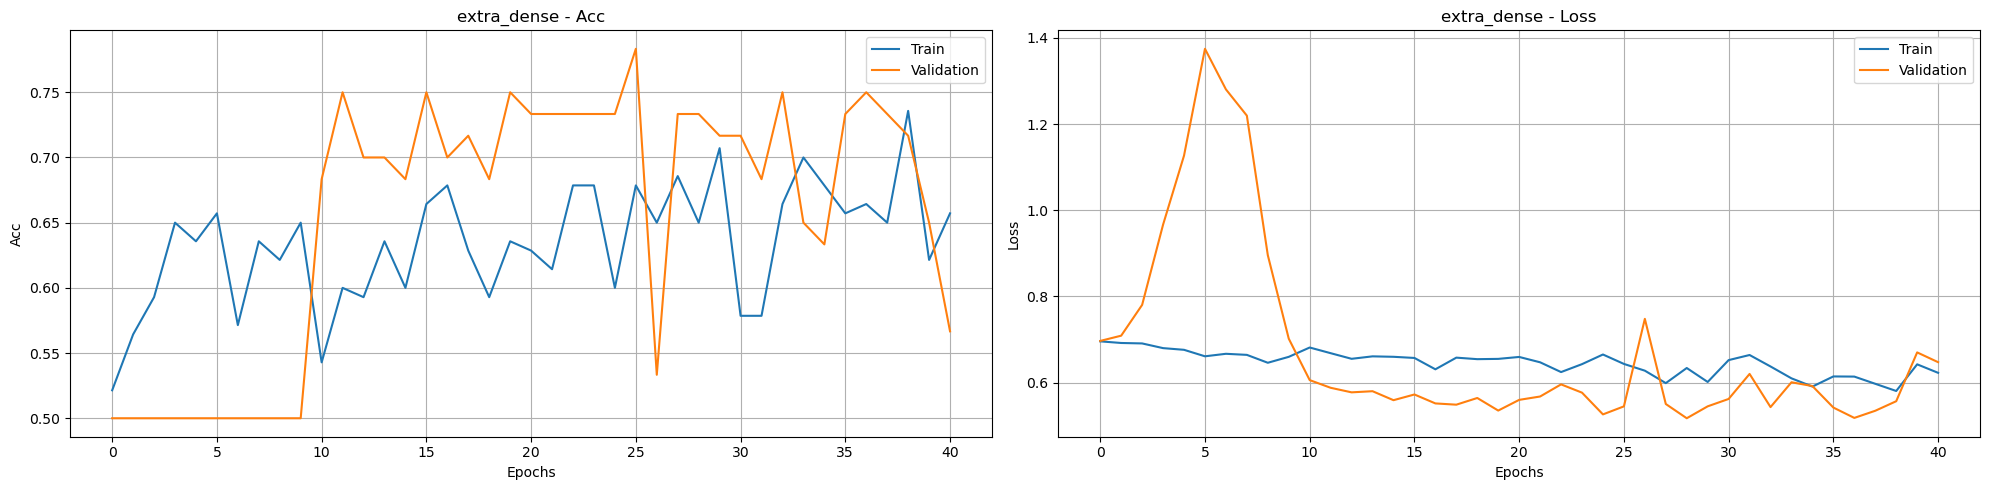

=== Gráficos para configuración: two_conv_per_level ===


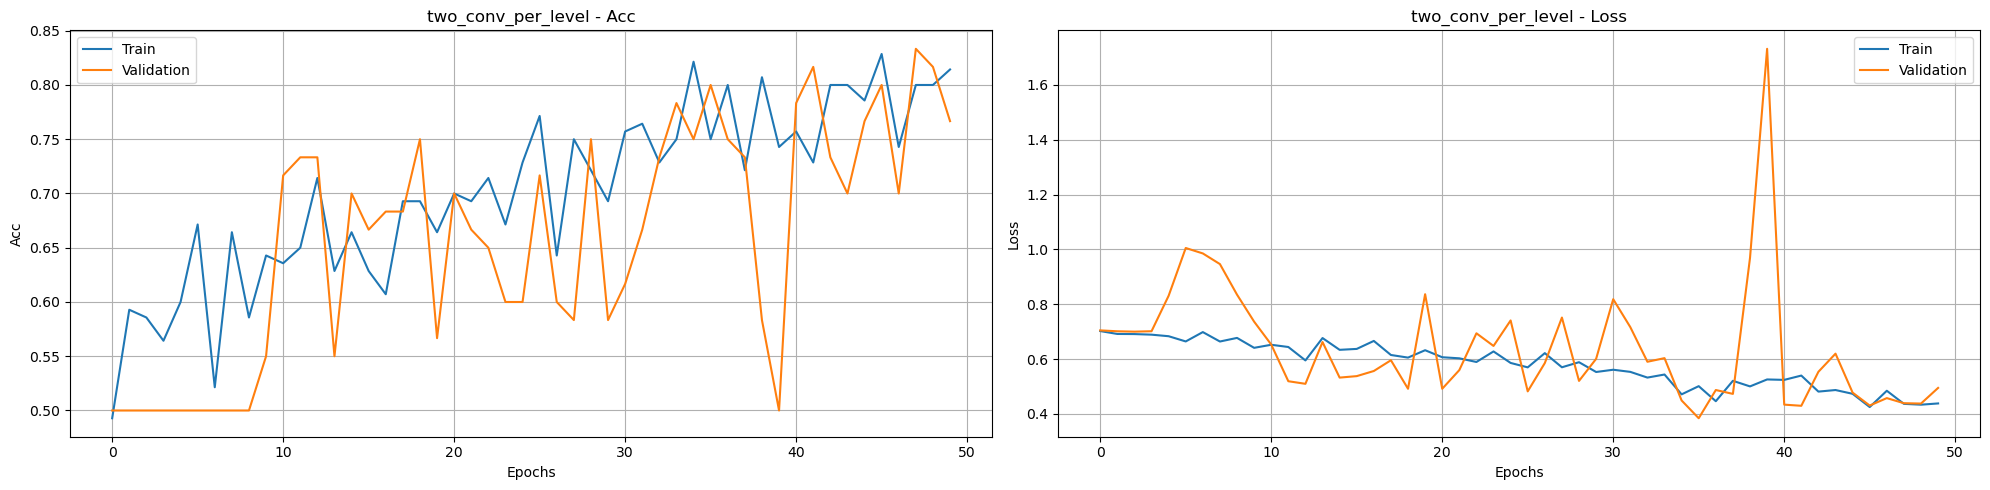

=== Gráficos para configuración: relu_to_sigmoid ===


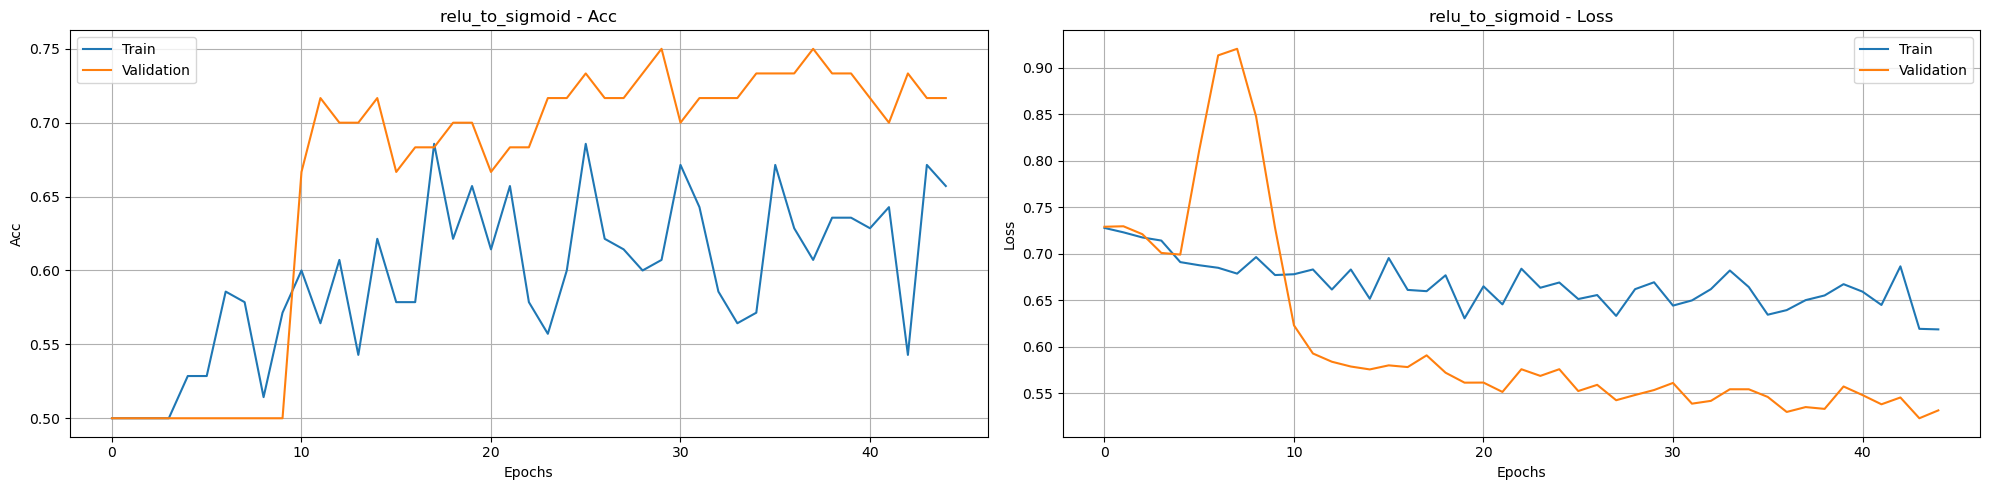

=== Gráficos para configuración: max_to_avg_pooling ===


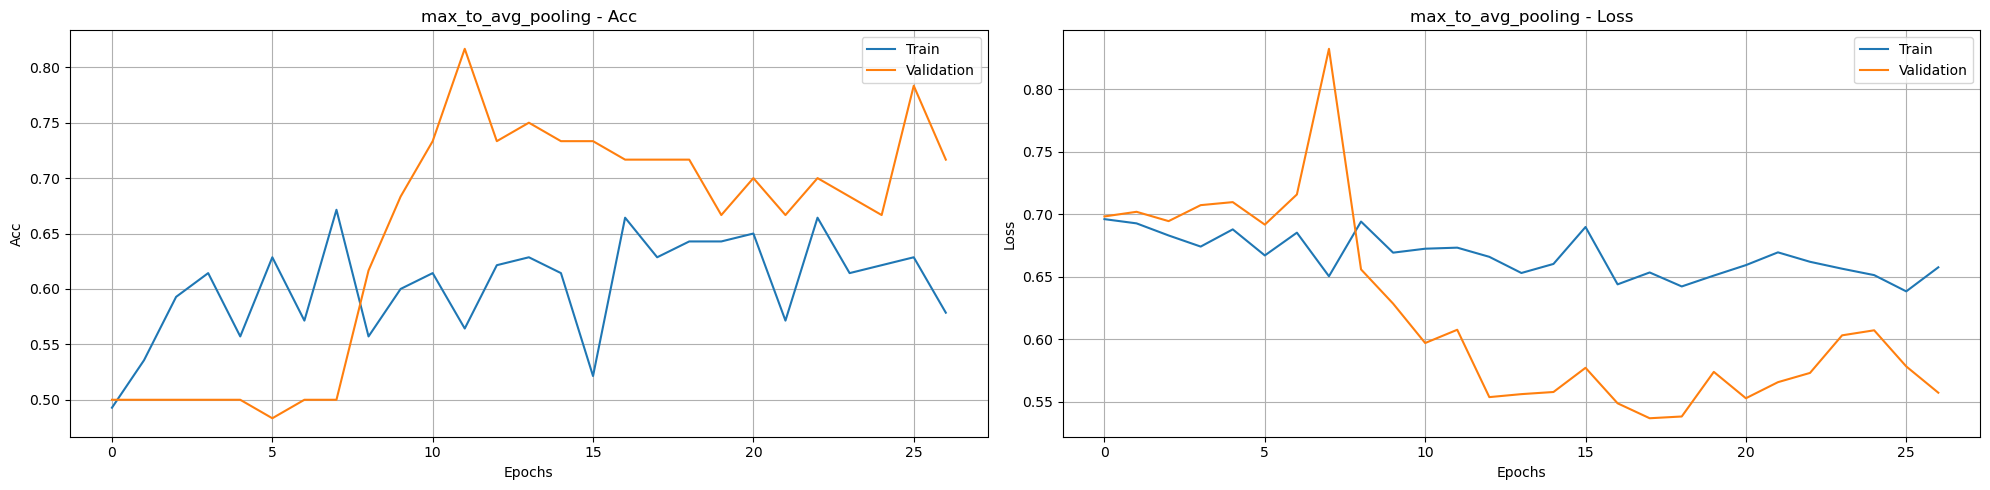

=== Gráficos para configuración: residual_blocks ===


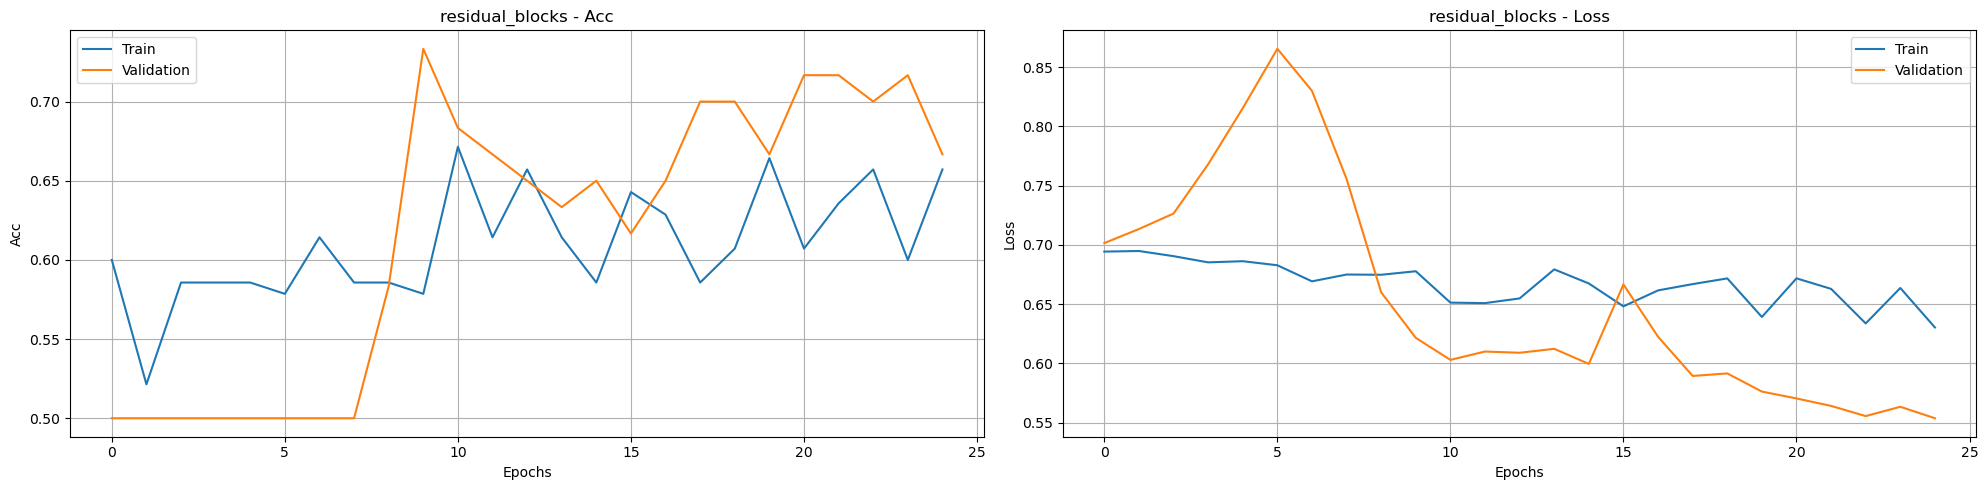

=== Gráficos para configuración: inception_blocks ===


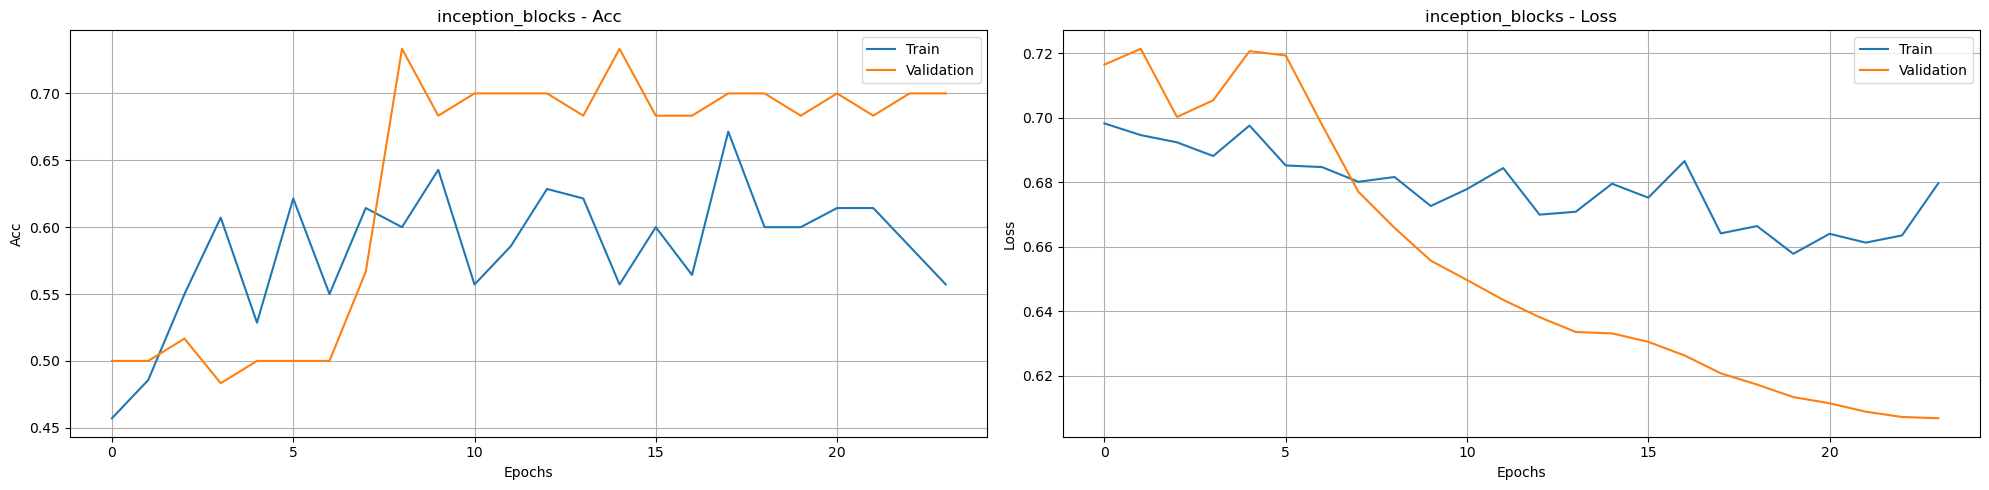

In [16]:
history_dir = "histories"

for config_name in df_results["config_name"]:
    history_path = os.path.join(history_dir, f"{config_name}_history.json")
    if os.path.exists(history_path):
        # Cargar historial desde JSON
        with open(history_path, "r") as f:
            history_data = json.load(f)

        # Imprimir gráficos en orden
        print(f"=== Gráficos para configuración: {config_name} ===")
        plot_training_history(history_data, config_name)
    else:
        print(f"Historial no encontrado para {config_name}: {history_path}")

### Best model predictions

In [19]:
best_model_name = best_model_row["config_name"]

models_dir = "models"
model_path = f"{models_dir}/{best_model_name}_model.h5"

best_model = load_model(model_path)

In [20]:
make_predictions(best_model)

I0000 00:00:1735057812.004002   35285 service.cc:148] XLA service 0x7fd17c013dc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735057812.004043   35285 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-12-24 17:30:12.019426: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735057812.068356   35285 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1735057812.831935   35285 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1735057812.924528   35285 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-12-24 17:30:15.458282: E externa

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
This model is 6.82% confident that the CT scan is normal.
This model is 93.18% confident that the CT scan is abnormal.


I0000 00:00:1735057817.032426   35285 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
